# Collaboration and Competition

---

In this notebook, a solution is provided to the third project in Udacity's Deep Reinforcement Learning Nanodegree.

The solution uses a single actor-critic style DDPG agent as the "brain" for both of the players in the game because in this game the observations for the two players are symetrical, and the players should react to the same state inputs with the same actions.

Both player's experiences are stored in a single replay buffer for the DDPG agent to learn. As shown below, the agent is able to solve the environment in 1500 episodes (100_episode_average_score=0.5), and further improves the score to 1.4+ at 1812 episode.

Here are the recorded actions of the agent before and after the training. It seems the agent learned to play the game pretty well.

### Before Training
![title](before_training.gif)

### After Training
![title](after_training.gif)

### 0. Start the environment and agent

We begin by importing the necessary packages, and initiate the enviroment as well as the DDPG agent.

In [1]:
import torch
import numpy as np
from collections import deque
from unityagents import UnityEnvironment
from ddpg_agent import Agent
import matplotlib.pyplot as plt

%matplotlib inline

# instantiate the environment and agent
env = UnityEnvironment(file_name="/home/labassistant/deep-reinforcement-learning/p3_collab-compet/Tennis_Linux/Tennis.x86_64")
agent = Agent(state_size=24, action_size=2, random_seed=2)

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# get the number of agents in the environment
env_info = env.reset(train_mode=True)[brain_name]
num_agents = len(env_info.agents)

working on cpu


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


### 1. Show the network archetecture

In [2]:
print('Local Actor Network:\n', agent.actor_local, '\n')
print('Target Actor Network:\n', agent.actor_target, '\n')
print('Local Critic Network:\n', agent.critic_local, '\n')
print('Target Critic Network:\n', agent.critic_target, '\n')

Local Actor Network:
 Actor(
  (fc1): Linear(in_features=24, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=4, bias=True)
  (fc3): Linear(in_features=4, out_features=2, bias=True)
) 

Target Actor Network:
 Actor(
  (fc1): Linear(in_features=24, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=4, bias=True)
  (fc3): Linear(in_features=4, out_features=2, bias=True)
) 

Local Critic Network:
 Critic(
  (fc1): Linear(in_features=24, out_features=32, bias=True)
  (fc2): Linear(in_features=34, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=8, bias=True)
  (fc4): Linear(in_features=8, out_features=1, bias=True)
) 

Target Critic Network:
 Critic(
  (fc1): Linear(in_features=24, out_features=32, bias=True)
  (fc2): Linear(in_features=34, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=8, bias=True)
  (fc4): Linear(in_features=8, out_features=1, bias=True)
) 



### 2. Define training process details

#### Hyper Parameters
- BUFFER_SIZE = 100000 (replay buffer size)
- BATCH_SIZE = 300 (minibatch size)
- GAMMA = 0.99 (discount factor)
- TAU = 1e-3 (for soft update of target parameters)
- LR_ACTOR = 1e-4 (learning rate of the actor)
- LR_CRITIC = 1e-3 (learning rate of the critic)

In [5]:
def ddpg(n_episodes=2000, print_every=400):
    
    scores_deque = deque(maxlen=100)
    scores = []
    best_score = 0
    environment_solved = False
    environment_solved_episode = 0
    best_performance_episode = 0
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        agent.reset()
        score = np.zeros(num_agents)
        while True:
            if i_episode > 1000:
                actions = agent.act(states, noise_level=0)
            else:
                actions = agent.act(states, noise_level=1)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            agent.memorize(states, actions, rewards, next_states, dones)
            states = next_states
            score += rewards
            agent.learn()
            if np.any(dones):
                break
        episode_score = np.max(score)
        scores_deque.append(episode_score)
        scores.append(episode_score)
        
        if (not environment_solved) and np.mean(scores_deque)>0.5 :
            environment_solved_episode = i_episode
            environment_solved = True
        
        if np.mean(scores_deque) > best_score:
            torch.save(agent.actor_local.state_dict(), 'best_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'best_critic.pth')
            best_score = np.mean(scores_deque)
            best_performance_episode = i_episode
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
    
    print(
        'Environment solved in {} episodes. Best average score of {} reached at {} episodes.'.format(
            environment_solved_episode, best_score, best_performance_episode))
    
    return scores

### 3. Start the training and plot the scores

Episode 400	Average Score: 0.07
Episode 800	Average Score: 0.09
Episode 1200	Average Score: 1.23
Episode 1600	Average Score: 0.13
Episode 2000	Average Score: 1.50
Environment solved in 1134 episodes. Best average score of 1.633600024357438 reached at 1394 episodes.


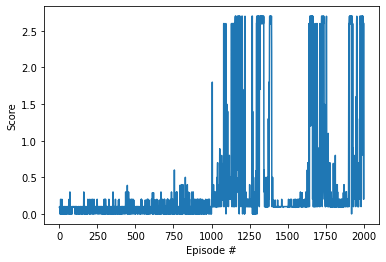

In [6]:
scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode')
plt.show()

#### 4. Future ideas

During the training it is found that the replay buffer size is important to the stabilize the learning. When the buffer size is set to a small value, the agent's single successful episode could fill up the buffer, and force the agent to learn from only that episode's data which led to unstatble scores. Thus what the agent learns from is criticle for the stability of the training. So to further improve the scores, it is believed that the prioritization of the replay buffer experiences would do the help.

In [7]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = agent.act(states, noise_level=0)              # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 2.7000000402331352
Score (max over agents) from episode 2: 2.600000038743019
Score (max over agents) from episode 3: 2.7000000402331352
Score (max over agents) from episode 4: 2.7000000402331352


KeyError: 'TennisBrain'

In [8]:
env.close()

ERROR:root:Exception calling application: Ran out of input
Traceback (most recent call last):
  File "/home/labassistant/anaconda3/envs/drlnd/lib/python3.6/site-packages/grpc/_server.py", line 385, in _call_behavior
    return behavior(argument, context), True
  File "/home/labassistant/anaconda3/envs/drlnd/lib/python3.6/site-packages/unityagents/rpc_communicator.py", line 26, in Exchange
    return self.child_conn.recv()
  File "/home/labassistant/anaconda3/envs/drlnd/lib/python3.6/multiprocessing/connection.py", line 251, in recv
    return _ForkingPickler.loads(buf.getbuffer())
EOFError: Ran out of input
ERROR:root:Exception calling application: [Errno 104] Connection reset by peer
Traceback (most recent call last):
  File "/home/labassistant/anaconda3/envs/drlnd/lib/python3.6/site-packages/grpc/_server.py", line 385, in _call_behavior
    return behavior(argument, context), True
  File "/home/labassistant/anaconda3/envs/drlnd/lib/python3.6/site-packages/unityagents/rpc_communicator